# Adventures in mosaic density!

Let's see what happens to optimal filters (a la Atick and Redlich) when we change the density of the mosaic.

In [1]:
#This version uses the Cx estimated from natural movies 
import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib 
import pickle
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

import seaborn as sns
import scipy.optimize as opt
import scipy.signal as ssig
from scipy.interpolate import interp1d
from scipy.special import softmax
from scipy.interpolate import RectBivariateSpline, BivariateSpline
import scipy

def softplus(x, beta=1): return np.log1p(np.exp(-np.abs(beta * x)))/beta + np.maximum(x, 0)

plt.rcParams.update({
    "text.usetex": True,
})

sns.set_context('talk')

%config InlineBackend.figure_format = 'retina'

np.random.seed(12346)
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [31]:
#sigout = 1.25
sigout = 2
nu = 1e-3
#A = np.array([100])

def soft_bandpass(lo, hi, freqs, stiffness=10):
    if lo <= 0:
        return scipy.special.expit(stiffness * (hi - freqs))
    else:
        return scipy.special.expit(stiffness * (freqs - lo)) * scipy.special.expit(stiffness * (hi - freqs))

#Original version of the code
#def C_prev(k, o):
#    return A/(np.abs(k)**alpha * np.abs(o)**2)

#def C(k,o,i):
#    eigval = A[i]/(np.abs(k)**alpha * np.abs(o)**2)  
#    return eigval

def import_C():
    with open(os.getcwd() + "/../../Cx.pkl", 'rb') as f:
        x = pickle.load(f)
    return x
hey = import_C()
n_time_freqs = hey['Cx_eigvals'].shape[1]//2
n_space_freqs = hey['Cx_eigvals'].shape[0]
Cx_pre = hey['Cx_eigvals'][:,0:n_time_freqs,:]
Cx_pre = np.flip(Cx_pre, axis = 2)
U = hey['Cx_eigvects'][:,0:n_time_freqs,:]
U = np.flip(U, axis = 3)
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        for c in range(U.shape[3]):
            if U[i,j,0,c] < 0:
                U[i,j,:,c] *= -1
#Cx = scipy.ndimage.gaussian_filter(Cx_pre, sigma = (2,0,0), order = 0)
Cx = scipy.ndimage.median_filter(Cx_pre, size = 5, axes = 0)
n_channels = Cx.shape[2]

def C_interpolate(k, o, i):
    #Fix: should not use integers for the first two inputs of RectVibarianteSpline. Use a fine grid. 
    func = RectBivariateSpline(np.arange(Cx.shape[0]), np.arange(Cx.shape[1]), np.log10(Cx[:,:,i]), s = 0)
    #return 10**func(k,o)/1000000000 #November 7th, 2024
    return 10**func(k,o)/1000000 #November 7th, 2024
    #John: Should keep the log values for as long as possible. 
    #John: Radial frequencies here are integers. But these are not the radial frequencies that generated these values; I should use the actual
    #radial frequencies instead. 

    #return 10**func(k,o)/10000000

def C(kk, oo, c):
    size1 = kk.shape[0]
    size2 = kk.shape[1]
    Cx_broad = np.zeros(kk.shape)
    for i in range(size1):
        for j in range(size2):
            Cx_broad[i,j] = Cx[int(kk[i,j]), int(oo[i,j]),c]
    return Cx_broad

def C_fix_k(C, k, i):
    def C(o):
        return RectBivariateSpline(np.arange(Cx.shape[0]), np.arange(Cx.shape[1]), Cx[:,:,i])

In [32]:


#First frequencies are positive, I shouldn't use fftshift!!!
#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_low = 0 
o_low = 0 
freqs_k_small = np.linspace(50,60,10)
freqs_omega_small = np.linspace(50,60,10)

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)

def create_information_eps(fixed_freq, freqs, fixed_type, return_sum = True):
    def information_eps(log_eps):
        infos = []
        for i in range(n_channels):
            eps_eigenchannel = 10**log_eps[i]
            if fixed_type == 'spatial':
                #ktilde = 1/Cx[int(fixed_freq),:, i]
                ktilde = 1/C_interpolate(int(fixed_freq), freqs, i)
            elif fixed_type == 'temporal':
                #ktilde = 1/Cx[:,int(fixed_freq), i]
                ktilde = 1/C_interpolate(freqs, int(fixed_freq), i)
            ktilde = pad_and_reflect(ktilde[:,0],ktilde.shape[0]*2 - 2)
            #numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-32)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) - 1) - sigout**2) + sigout**2
            #denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) + 1) - sigout**2) + sigout**2

            numer = np.maximum(0, 1/(2 * (ktilde + 1e-32)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) - 1) - 1) + 1
            denom = np.maximum(0, 1/(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) + 1) - 1) + 1
            
            
            info = np.sum(np.log(numer) - np.log(denom))
            infos.append(info)
        if return_sum:
            return np.sum(infos)*-1
        else:
            return infos 
    return information_eps

def filter_k(fixed_freq, indices, eps, fixed_type, channel, k_lims=None, return_ktilde = False):
    def v_opt(indices):
        if fixed_type == 'spatial':
            inter = np.clip(C_interpolate(int(fixed_freq),indices, channel), 1e-32, np.inf).T
            ktilde = 1/inter
        elif fixed_type == 'temporal':
            inter = np.clip(C_interpolate(indices, int(fixed_freq), channel), 1e-32, np.inf)
            ktilde = 1/inter
        ktilde = pad_and_reflect(ktilde[:,0],ktilde.shape[0]*2 - 2)
        sqrt_piece = np.sqrt(1 + (4/eps) * ktilde)
        
        v2 = 0.5 * (sqrt_piece + 1) / (1 + ktilde) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2)
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        if not return_ktilde:
            return v2
        else:
            return ktilde
    return v_opt

def filter(C, nu, k_lims=None):
    def v_opt(k, o, i):
        CC = np.minimum(C_interpolate(k, o, i), 1e32)
        sqrt_piece = np.sqrt(1 + 4/(nu * sigout**2 * CC))
        v2 = 0.5 * (sqrt_piece + 1) * (CC/(1 + CC)) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2)
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k

        return v2 #- np.min(v2)
    return v_opt

def pad_and_reflect(filter, N, padval=0):
    """
    Zero-pad to length N//2 and reflect about origin to make length N. 
    """
    expanded = np.pad(filter, (0, N//2 + 1 - len(filter)), constant_values=(0, padval))
    return np.concatenate([expanded[::-1], expanded[1:]])

def extrap_and_reflect(filter, N, return_log=False):
    """
    Linearly extrapolate the log filter to better approximate tails and reflect 
    about origin to make length N.
    """
    extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
    expanded = extrap_fun(range(0, N//2 + 1))
    if not return_log:
        expanded = np.exp(expanded)
    return np.concatenate([expanded[::-1], expanded[1:]])

def filter_power(eps, fixed_freq, indices, klims, channel, fixed_type):
    vfun = filter_k(fixed_freq, indices, eps, fixed_type, channel, klims)
    v2 = vfun(indices)
    if fixed_type == 'spatial':
        ktilde = 1/C_interpolate(int(fixed_freq), indices, channel)
    elif fixed_type == 'temporal':
        ktilde = 1/C_interpolate(indices, int(fixed_freq), channel)
    #Great point: Pad and reflect should not be on ktilde but on Cx 
    #Other point: indices should not be integers, but grid should be as fine as possible. Should just be a range. 
    ktilde = pad_and_reflect(ktilde[:,0],ktilde.shape[0]*2 - 2)

    dk = 2*np.pi/len(indices)

    freqs = indices*2*np.pi/len(indices)
    freqs = pad_and_reflect(freqs, len(freqs)*2 - 2)

    #return np.sum(v2**2 * np.abs(freqs) * (ktilde + 1) * dk)/(2 * np.pi)**2
    return np.sum(v2**2 * np.abs(freqs) * (1/ktilde + 1) * dk)/(2 * np.pi)
    return np.sum(v2**2 * np.abs(freqs) * (Ck + sigin**2) * dk)/(2 * np.pi)**2 #Original version
    #John: Needs to make sure I do the conversion from integral to sum correctly
    #Need to make srue dk is the correct value. dk = 2*pi/L
    #By convention, frequencies discrete are -pi to pi. My frequencies are from 0 to L. 

def excess_power(log_eps, fixed_freq, indices, klims, P, fixed_type):
    total_power = 0
    for i in range(n_channels):
        eig_power = filter_power(10**log_eps[i], fixed_freq, indices, klims, i, fixed_type)
        total_power += eig_power
    return P - total_power

def optimal_logeps(fixed_freq, indices, klims, P, fixed_type):
    power_constraint = {'type': 'ineq', 'fun': excess_power, 'args': (fixed_freq, indices, klims, P, fixed_type)}
    eps_fun = create_information_eps(fixed_freq, indices, fixed_type)
    res = opt.minimize(eps_fun, np.array([-10,-10,-10]), bounds=[(-16, np.inf)], constraints=[power_constraint])
    if res.success:
        #print("Excess power: ", excess_power(res.x, fixed_freq, indices, klims, P, fixed_type))
        return res.x
    else:
        print("Optimizer failed to converge!")
        return None

[1.02147137 1.25901028 0.02112504]
[1.33543388 0.1336151  0.06456255]
Zero vspace for kf:  10 0
Zero vspace for kf:  10 1
Zero vspace for kf:  10 2
[0.56952243 0.65201667 0.01785422]
Zero vspace for kf:  20 0
Zero vspace for kf:  20 1
Zero vspace for kf:  20 2
[1.06503904 0.02191988 0.01814091]
Zero vspace for kf:  30 0
Zero vspace for kf:  30 1
Zero vspace for kf:  30 2


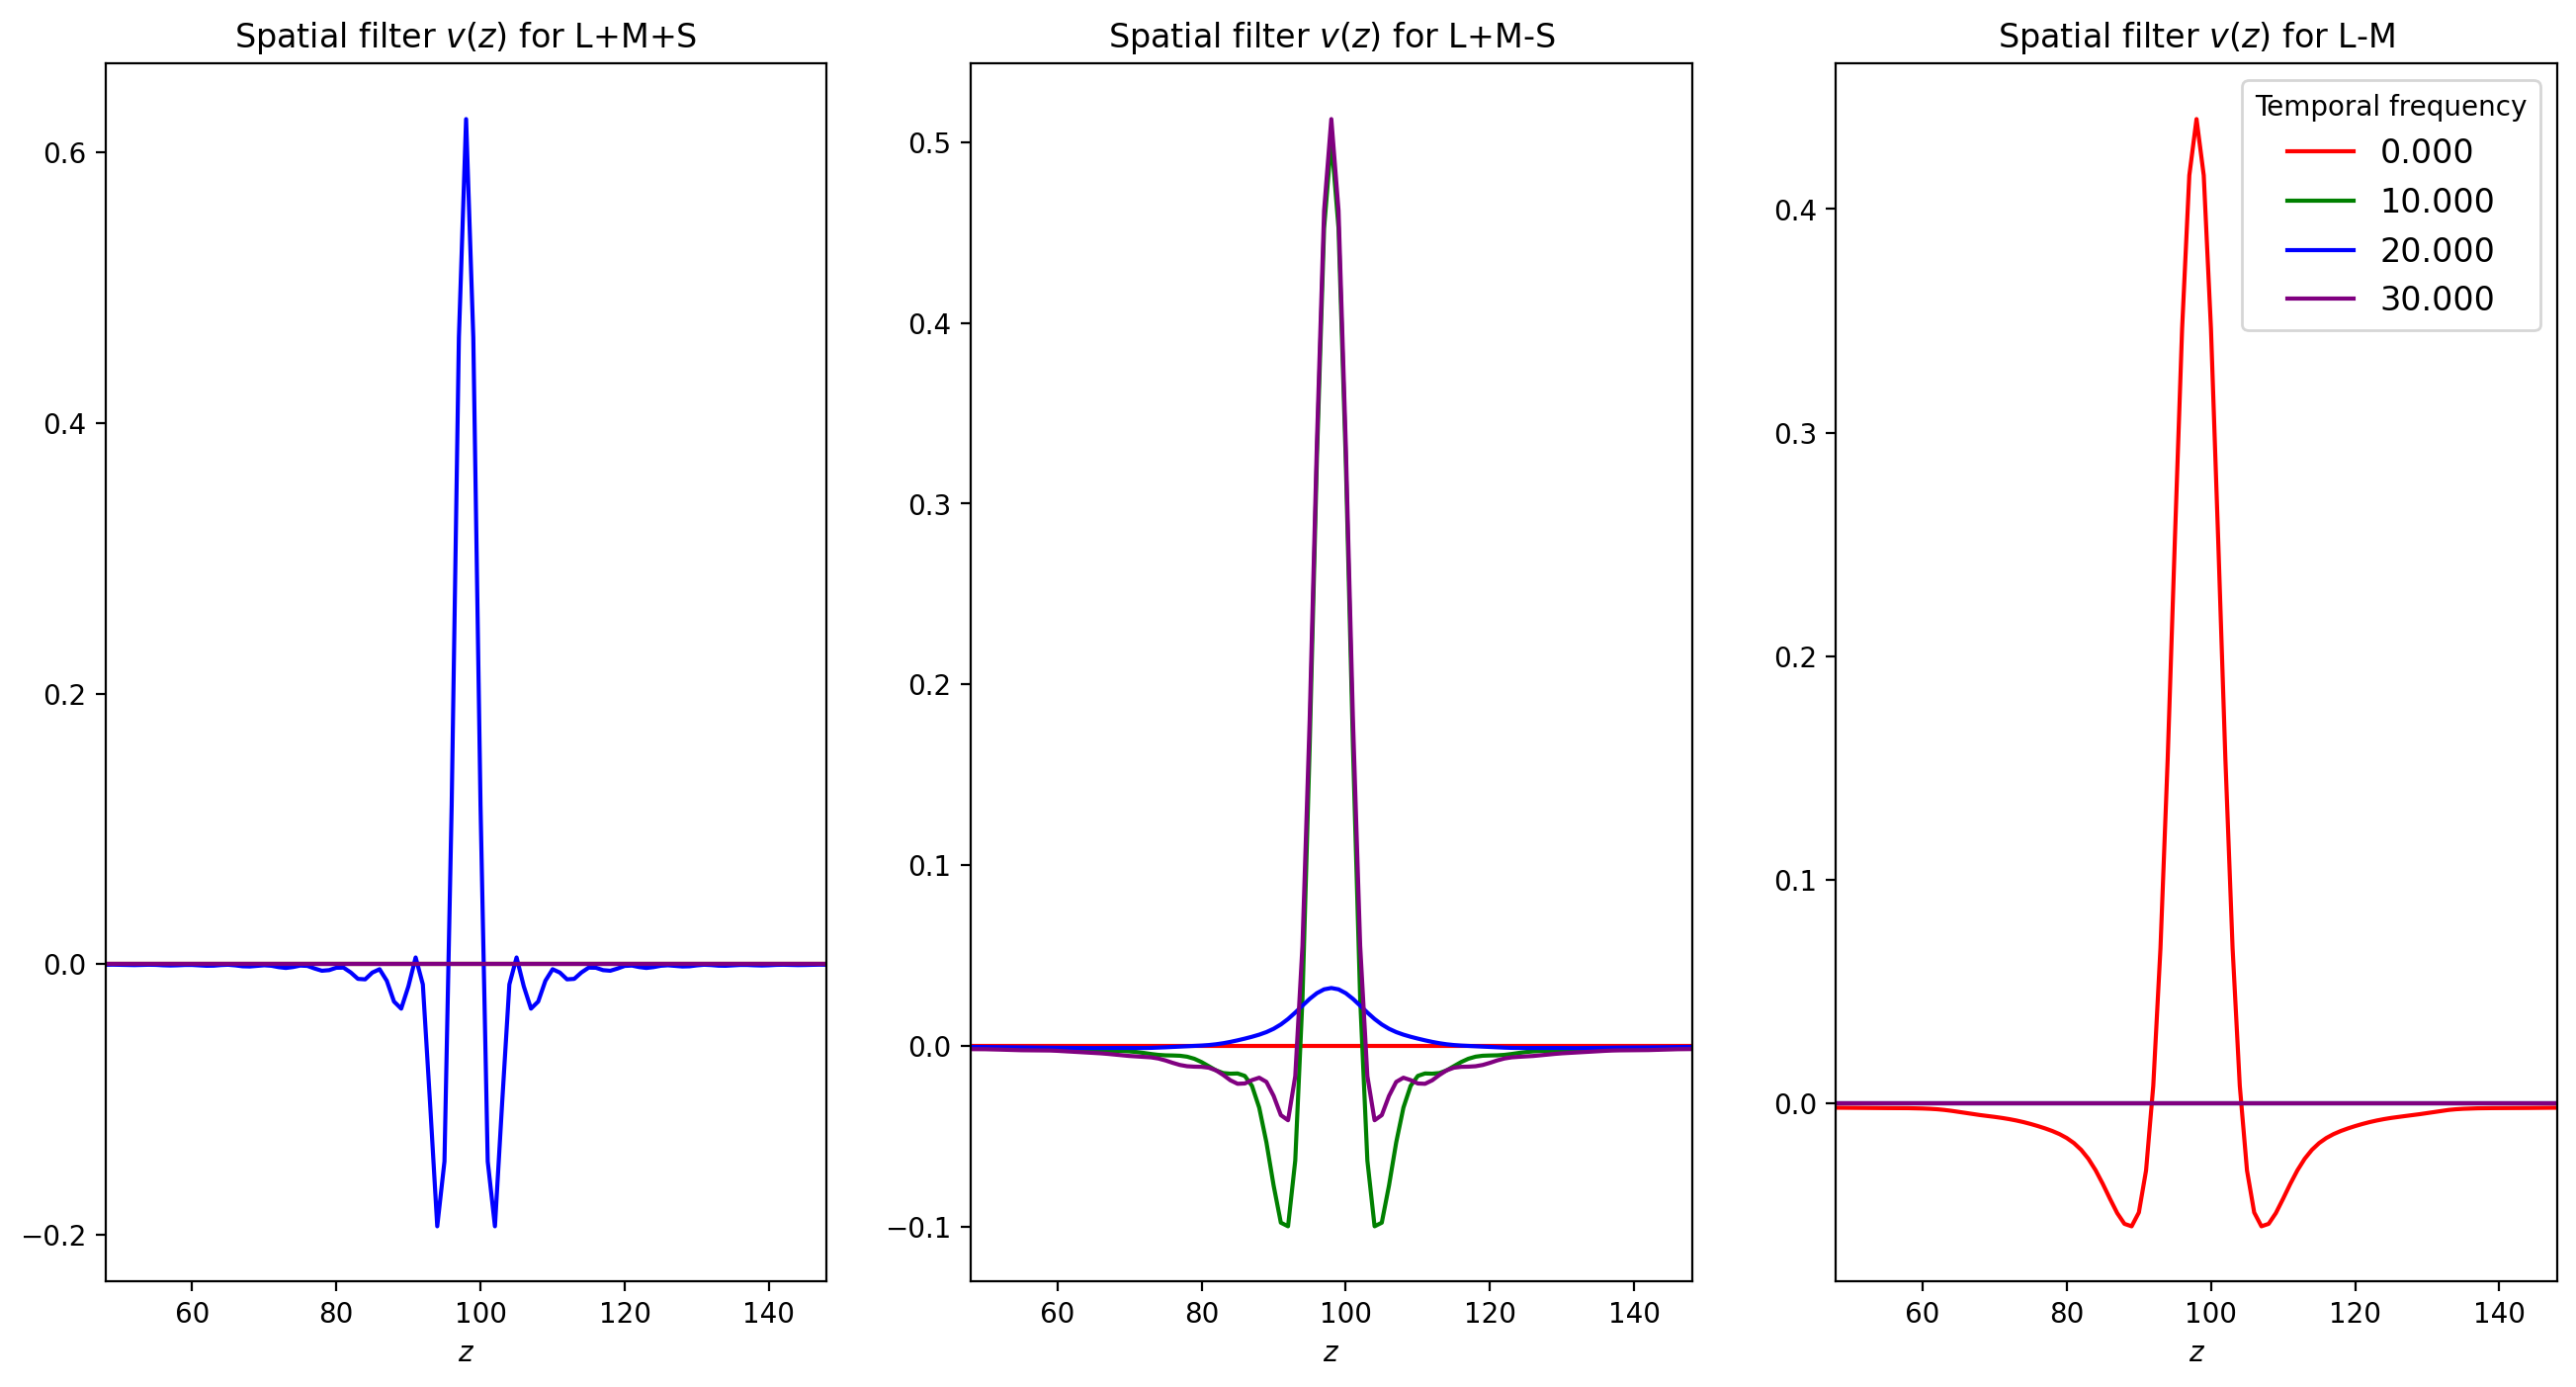

In [33]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_min = 0
k_max = 98
k_indices = np.linspace(k_min, k_max -1, k_max - k_min)
omega_indices = np.array([0,10,20,30])
#omega_indices = np.array([0,15,45,65])

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []


colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']

for fixed_omega in omega_indices:
    log_eps = optimal_logeps(fixed_omega, k_indices, None, P, 'temporal')
    #log_eps = log_eps[::-1]
    print(10**log_eps)
    vspace_omega = []
    for i in range(n_channels):
        vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)
        #vv = vv[:,0]
        #vv = vv[::-1]
        vv_all.append(vv)
        #if np.max(vv) > 0:
        #vf = np.convolve(vv[N//2:], ff, mode='same')
        #Remove negative frequencies from vv
        #print("Hello Sir", vv.shape, vv.shape[0]//2)
        vv = vv[vv.shape[0]//2:]
        

        vf = np.convolve(vv, ff, mode = 'same')
        vf_all.append(vf)
        #The bug is here :) in the fft convention~
        #print(vf.shape)
        vvf = pad_and_reflect(vf, vf.shape[0]*2)
        #vvf = vf
        
        vvf_all.append(vvf)
        vspace = np.real(scipy.fft.fft(vvf))
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        vspace_omega.append(vspace)
        vspace_all.append(vspace)
    vspace_omega = np.array(vspace_omega)
    vspace_omega /= np.linalg.norm(vspace_omega)
    for i in range(n_channels):
        if np.mean(vspace) == 0:
            print("Zero vspace for kf: ", fixed_omega, i)
        #line, = ax[i].plot(zz, vspace, color = colors[c], label = str(('{:.3f}').format(fixed_omega)))
        line, = ax[i].plot(vspace_omega[i,:], color = colors[c], label = str(('{:.3f}').format(fixed_omega)))
        
        center = int(vspace.shape[0]/2)
        plot_range = 50
        ax[i].set_xlim(center - plot_range, center + plot_range)   
        #ax[i].set_yticks([])
        ax[i].set_xlabel(r"$z$")
        ax[i].set_title(r"Spatial filter $v(z)$ for " + channel_labels[i]);
        #else:
           # print("Filter was zero for channel " + str(i) + " at temporal frequency " + str(fixed_omega))
    lines.append(line)
    c += 1    
ax[i].legend(handles=lines, title = "Temporal frequency", fontsize = 12)
    #ax[0].text(*label_loc, r'\textbf{B}', transform=ax[0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    #cbar = fig.colorbar(s)
    #cbar.ax.tick_params(labelsize=50)

In [34]:
powers

array([[0.37133712, 0.54043432, 0.08822859],
       [0.77978306, 0.22021711, 0.        ],
       [0.91101883, 0.08898117, 0.        ],
       [0.94224627, 0.05775374, 0.        ]])

log_eps:  [ 1.5651969   0.00586266 -0.61511347]


/tmp/ipykernel_1063274/3588433721.py:86: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')


log_eps:  [ 1.0188286  -0.0169152  -3.00101559]
log_eps:  [ 1.10850197 -0.66436523 -2.7761582 ]
log_eps:  [ 0.34303841 -1.06828187 -2.96140447]


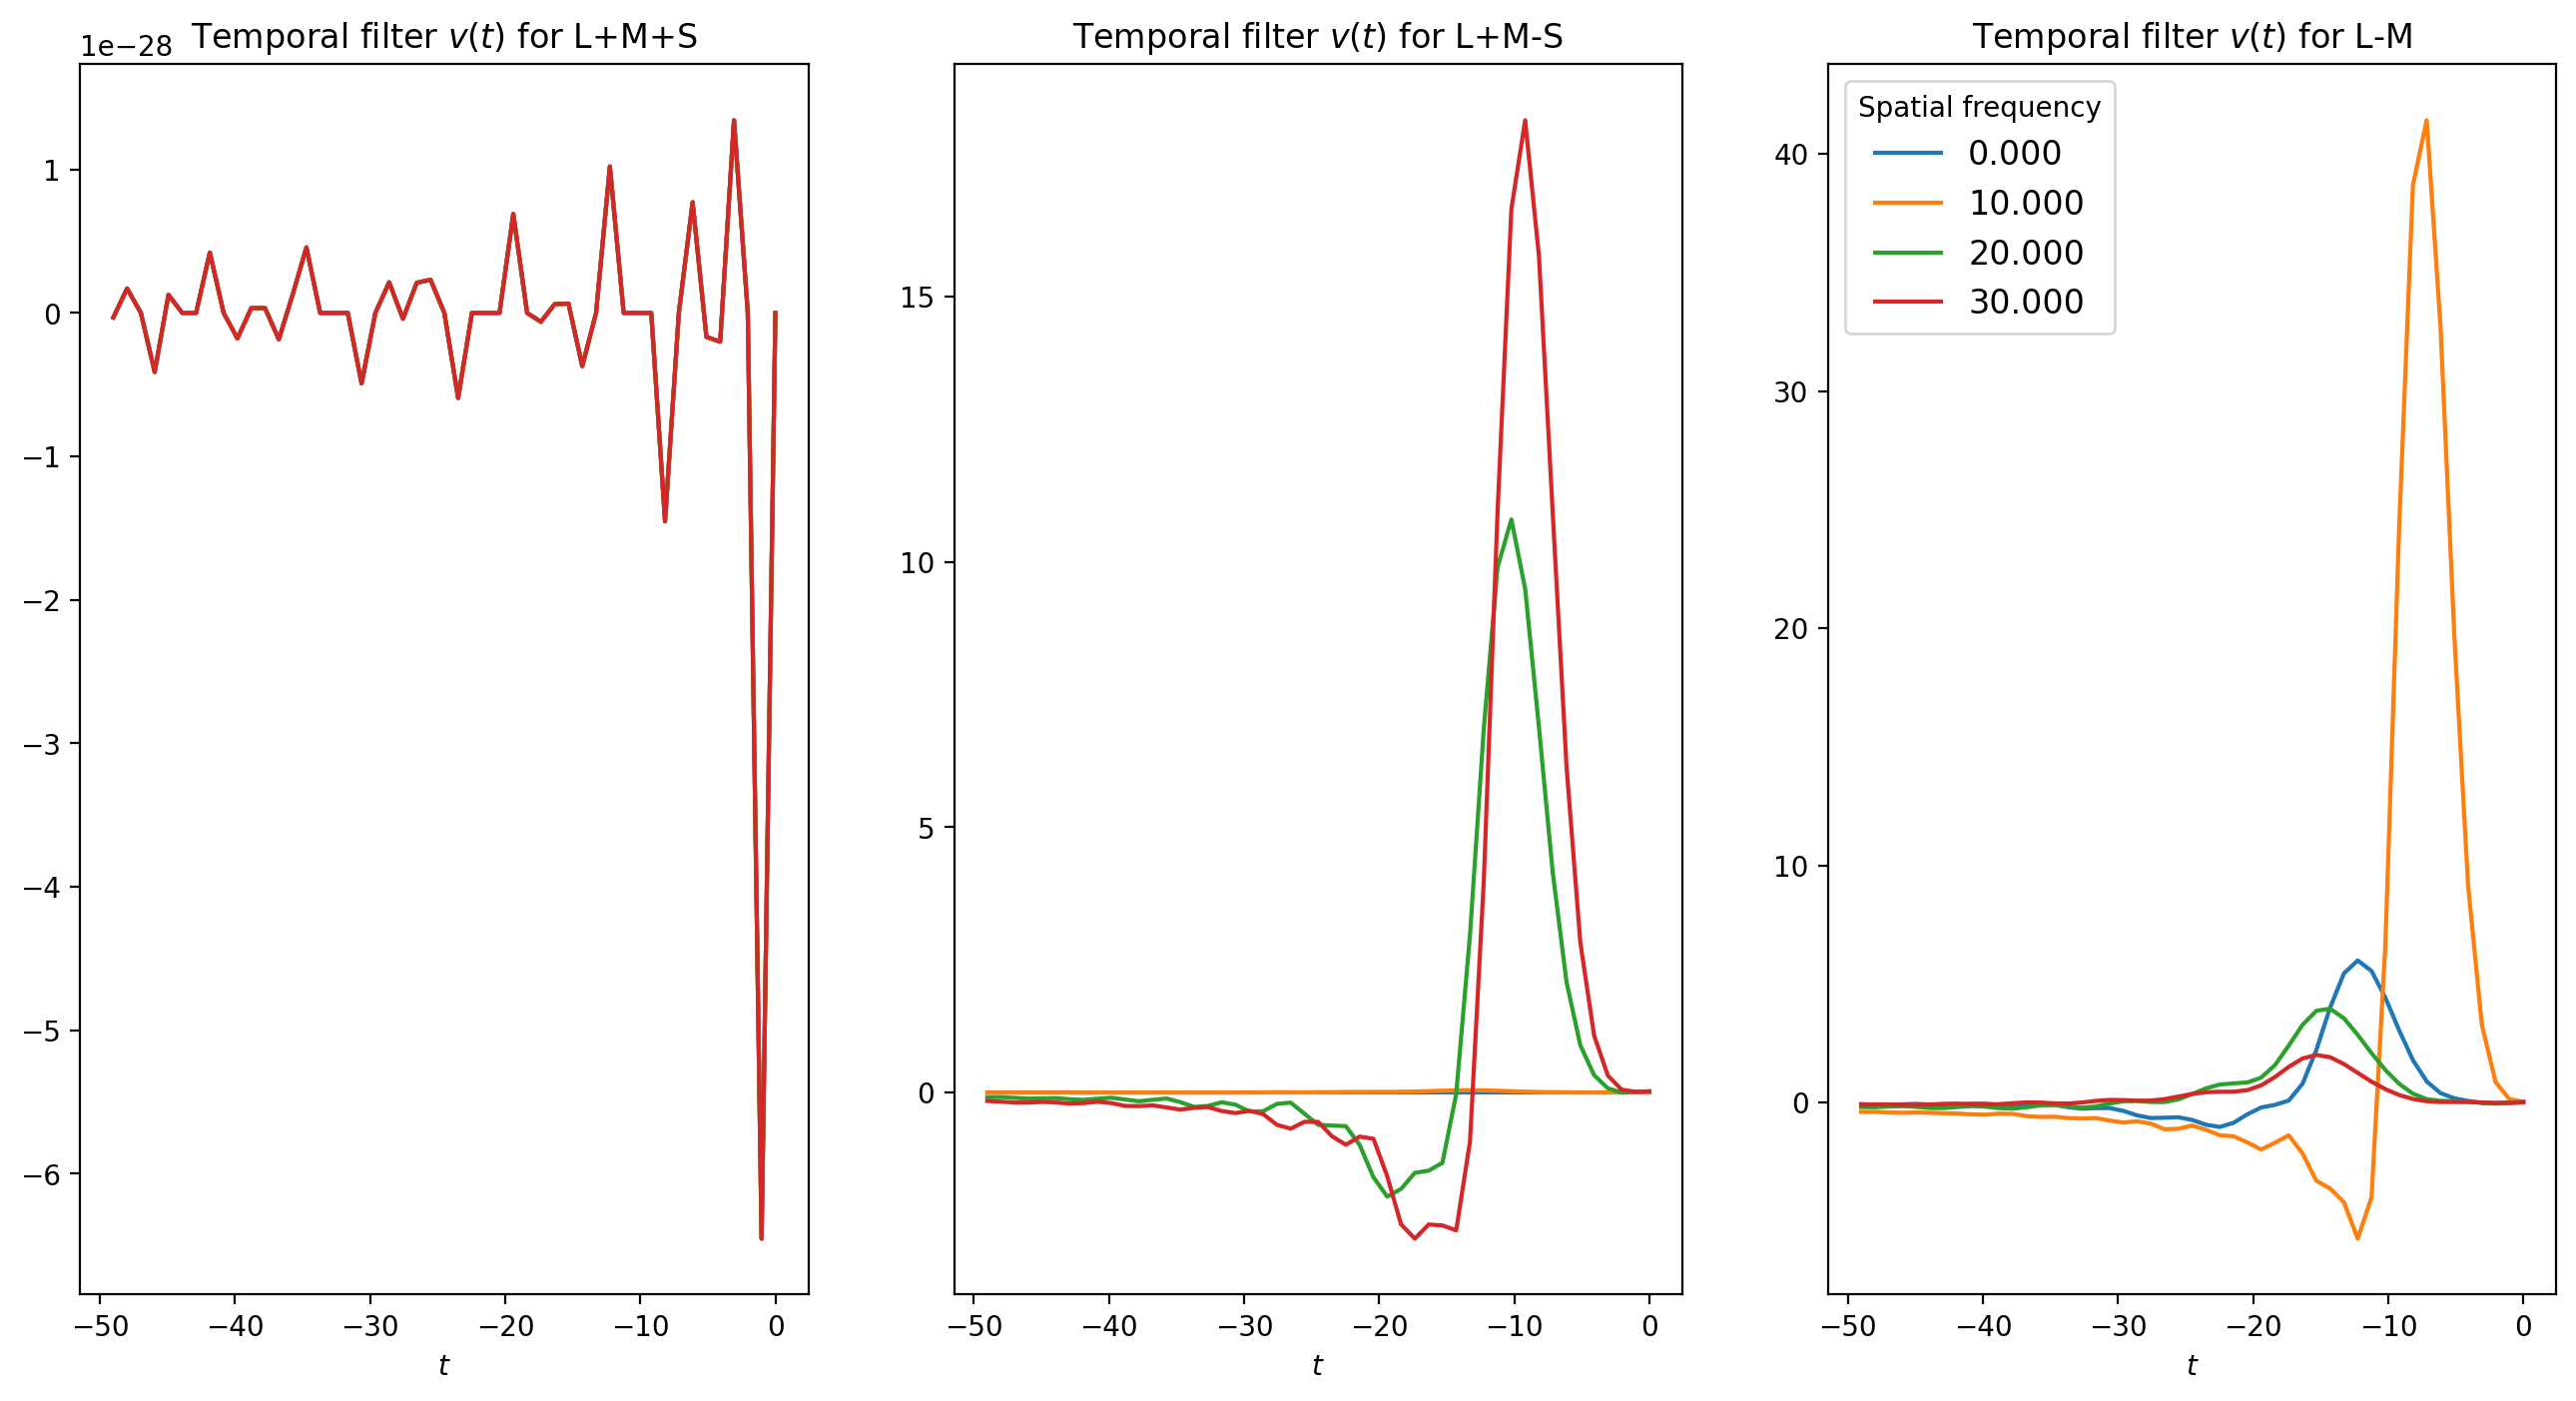

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

w_min = 0
w_max = 50
k_indices = np.array([0,10,20,30])
w_indices = np.linspace(w_min, w_max -1, w_max - w_min)

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []
vt_all = []


colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']

for fixed_k in k_indices:
    log_eps = optimal_logeps(fixed_k, w_indices, None, P, 'spatial')

    print("log_eps: ", log_eps)
    vts = []
    for i in range(n_channels):
        vv = filter_k(fixed_k, w_indices, 10**log_eps[i], 'spatial', i)(w_indices)
        #Prevents artifacts when output filter is 0 for all freqs. 
        vf = np.convolve(vv[vv.shape[0]//2:], ff, mode='same')
        
        log_v = extrap_and_reflect(vf, vv.shape[0], return_log=True)
        log_v_a = np.conj(ssig.hilbert(log_v))
        vt = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
        vv_all.append(vv)
        vt_all.append(vt)
        vts.append(vt)
    vts = np.array(vts)
    #vts /= np.linalg.norm(vts)
    t_length = int((vts.shape[1]-1)/2)
    for i in range(n_channels):
        line, = ax[i].plot(np.linspace(-t_length,0, t_length),vts[i,0:t_length], label = str(('{:.3f}').format(fixed_k)))
        if i == 0:
            lines.append(line)
        #ax[i].set_xlim(-0.35, 0.05)
        ax[i].set_xlabel(r"$t$")
        #ax[i].set_yticks([])
        ax[i].set_title(r"Temporal filter $v(t)$ for " + channel_labels[i]);
ax[i].legend(handles=lines, title = "Spatial frequency", fontsize = 12)


/tmp/ipykernel_1063274/3588433721.py:86: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')


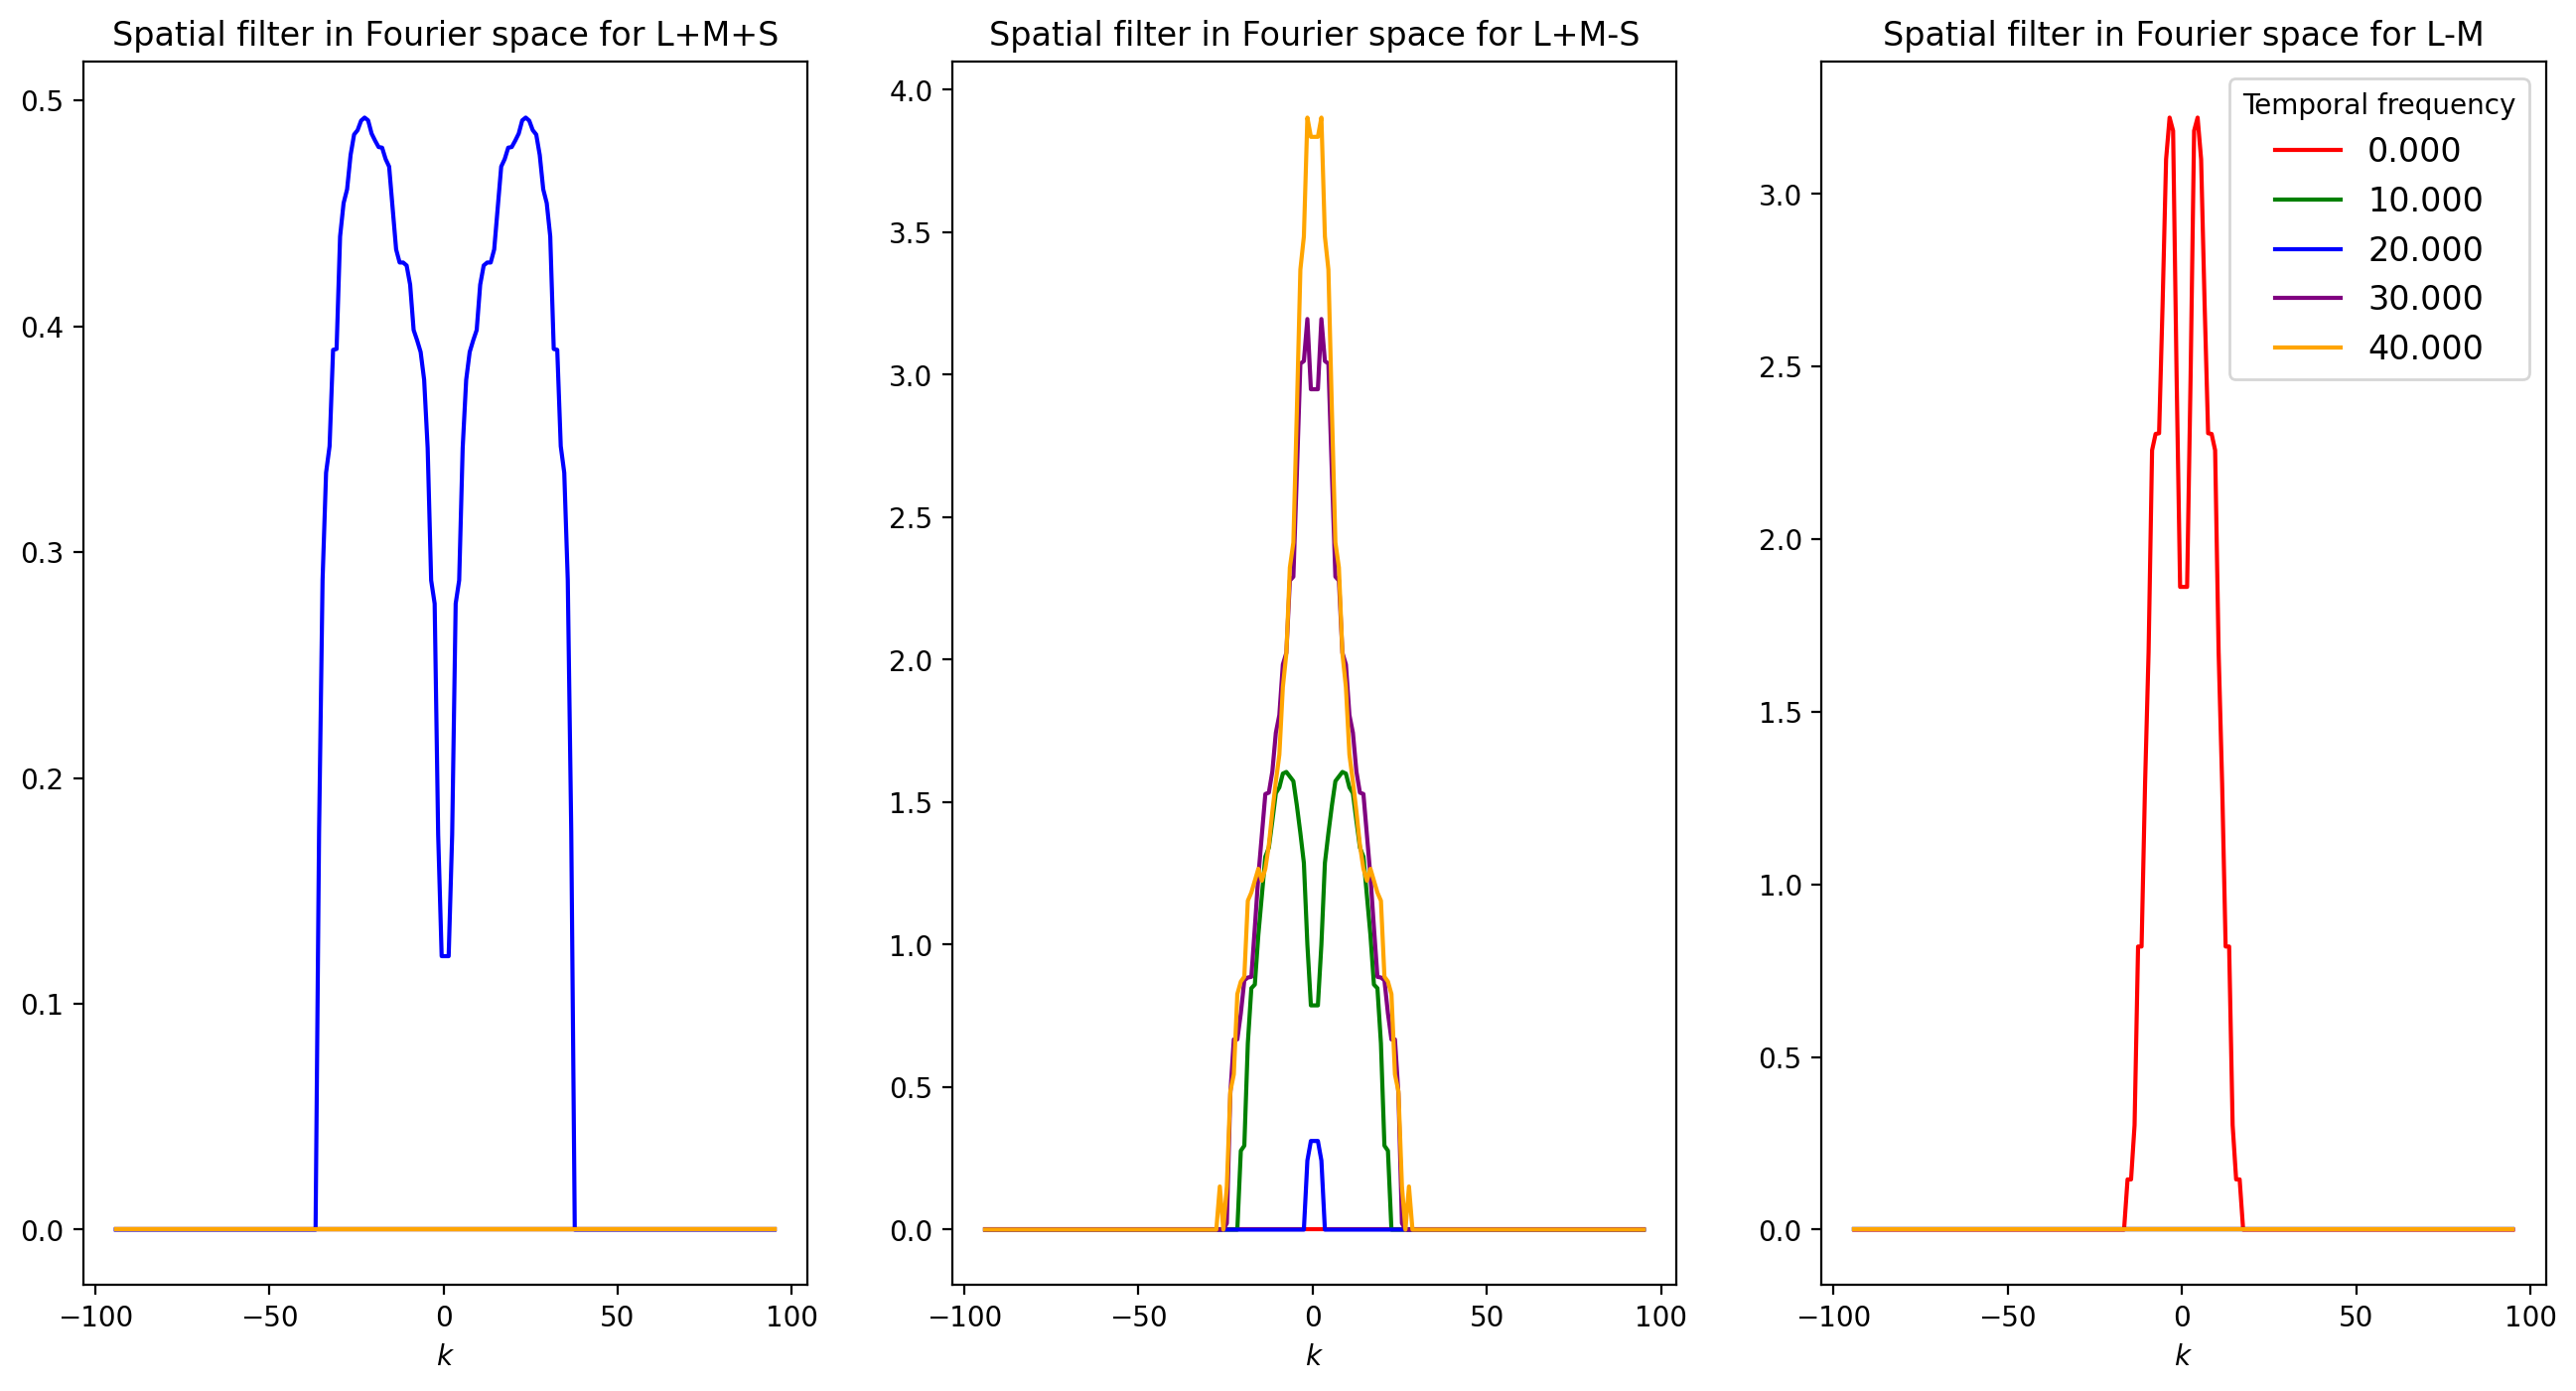

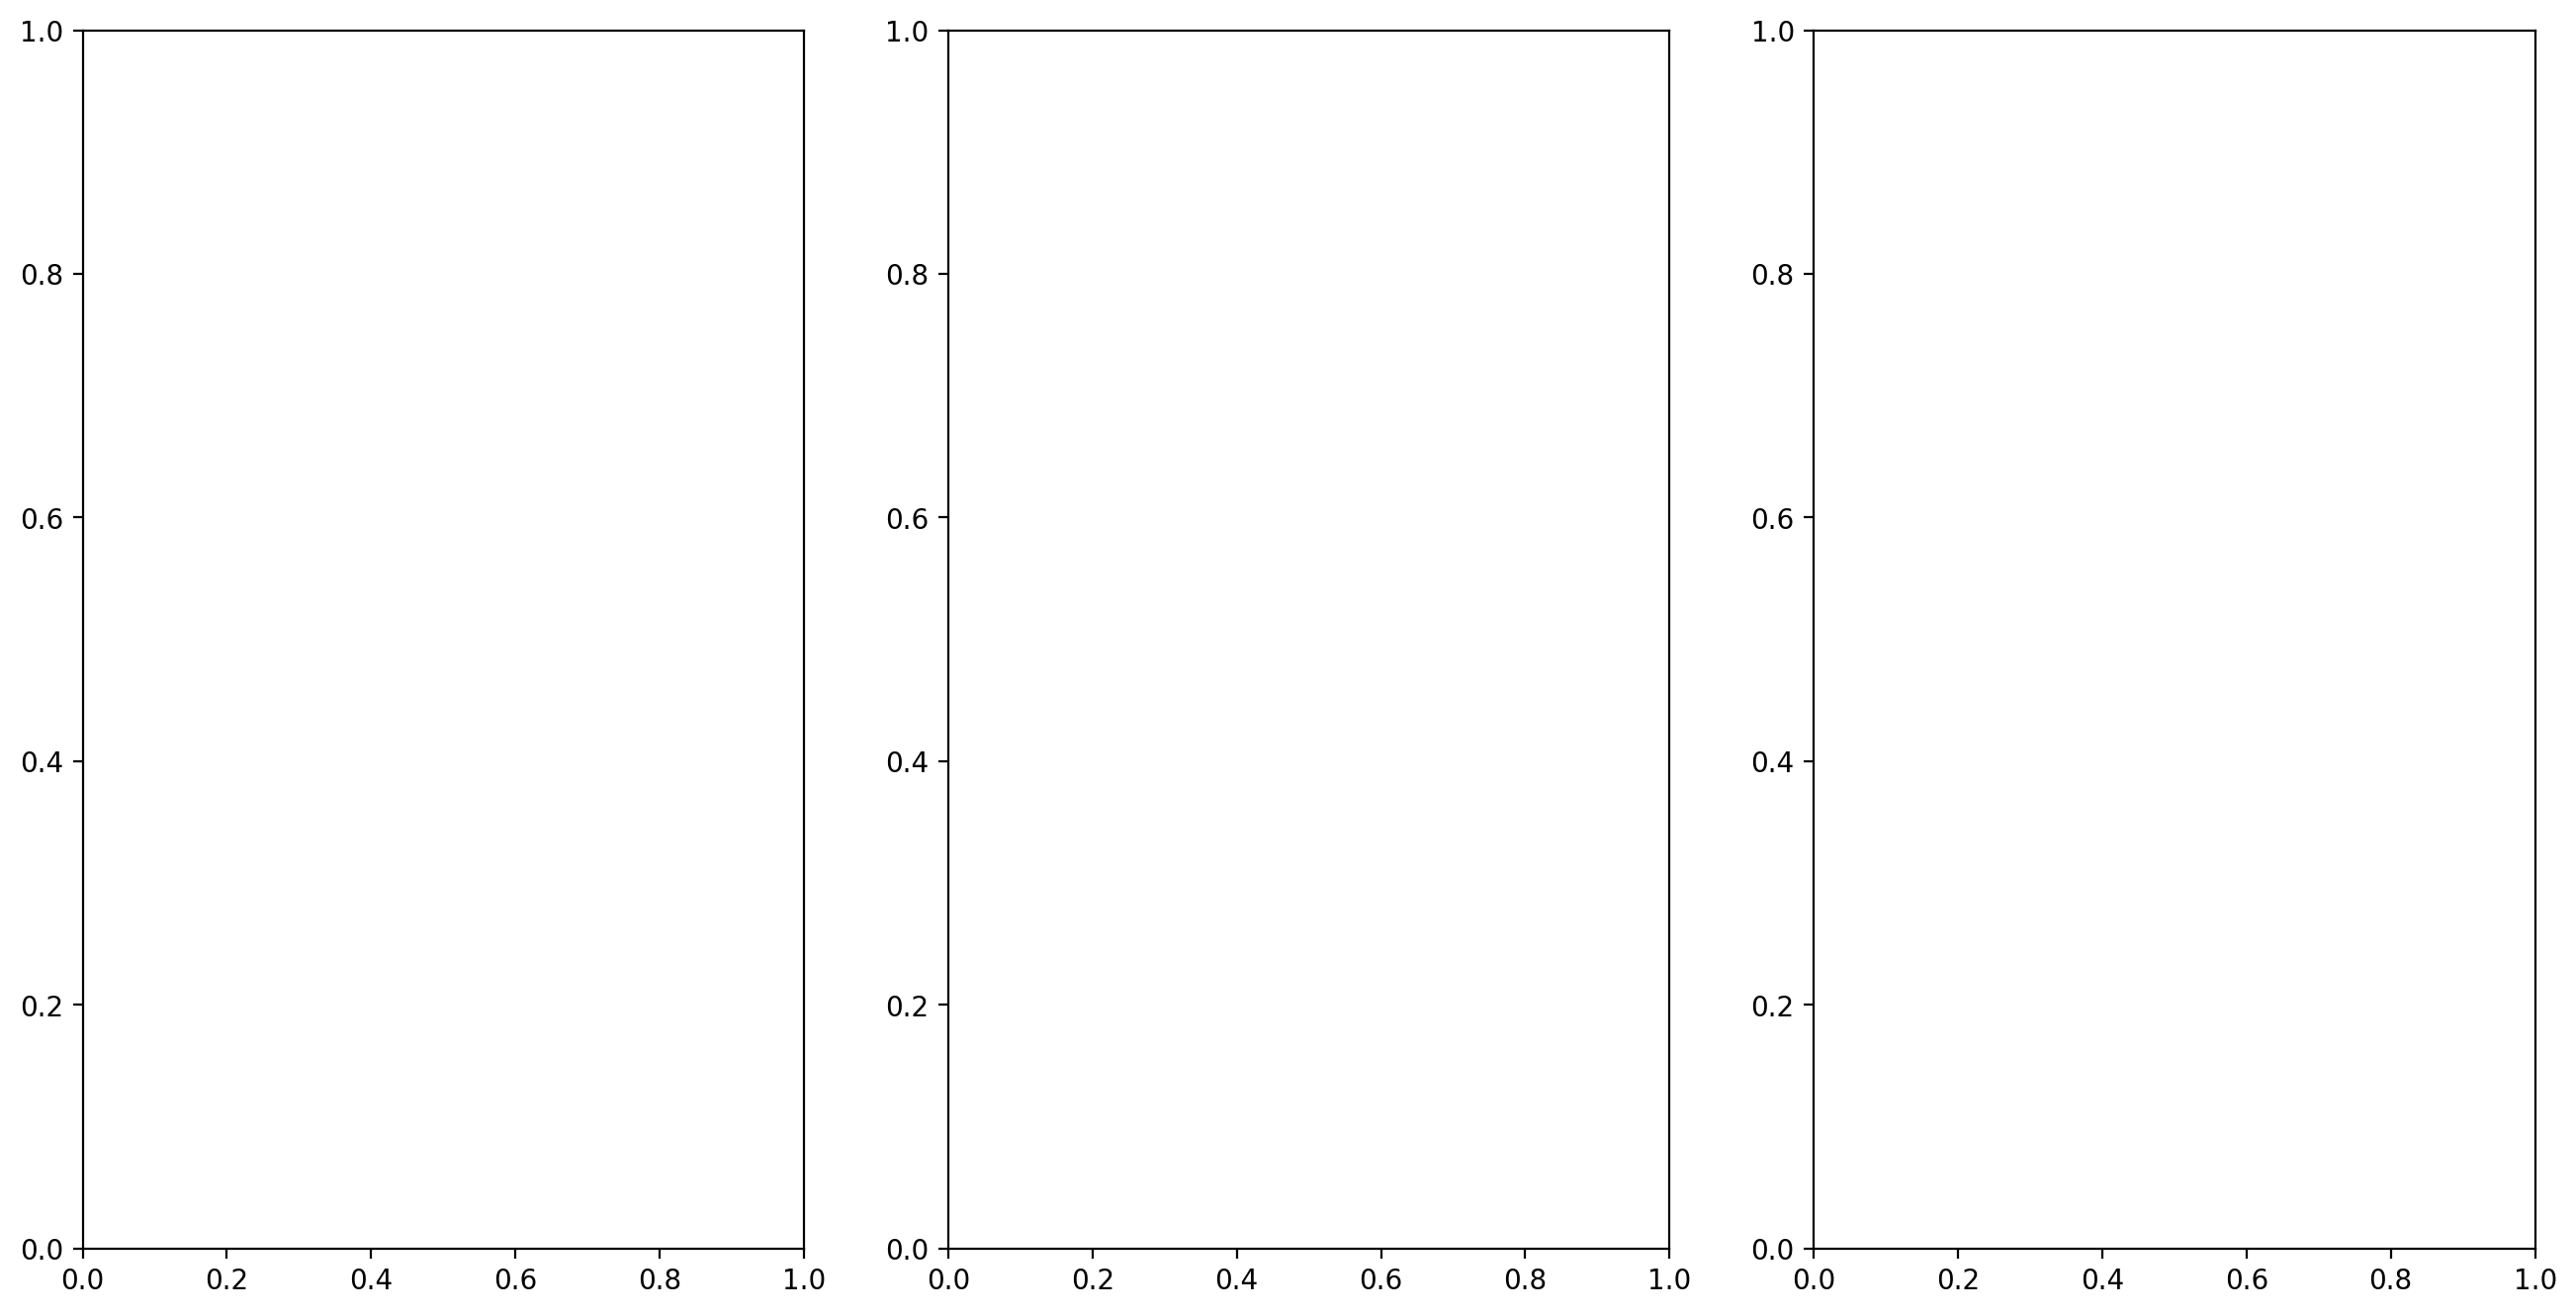

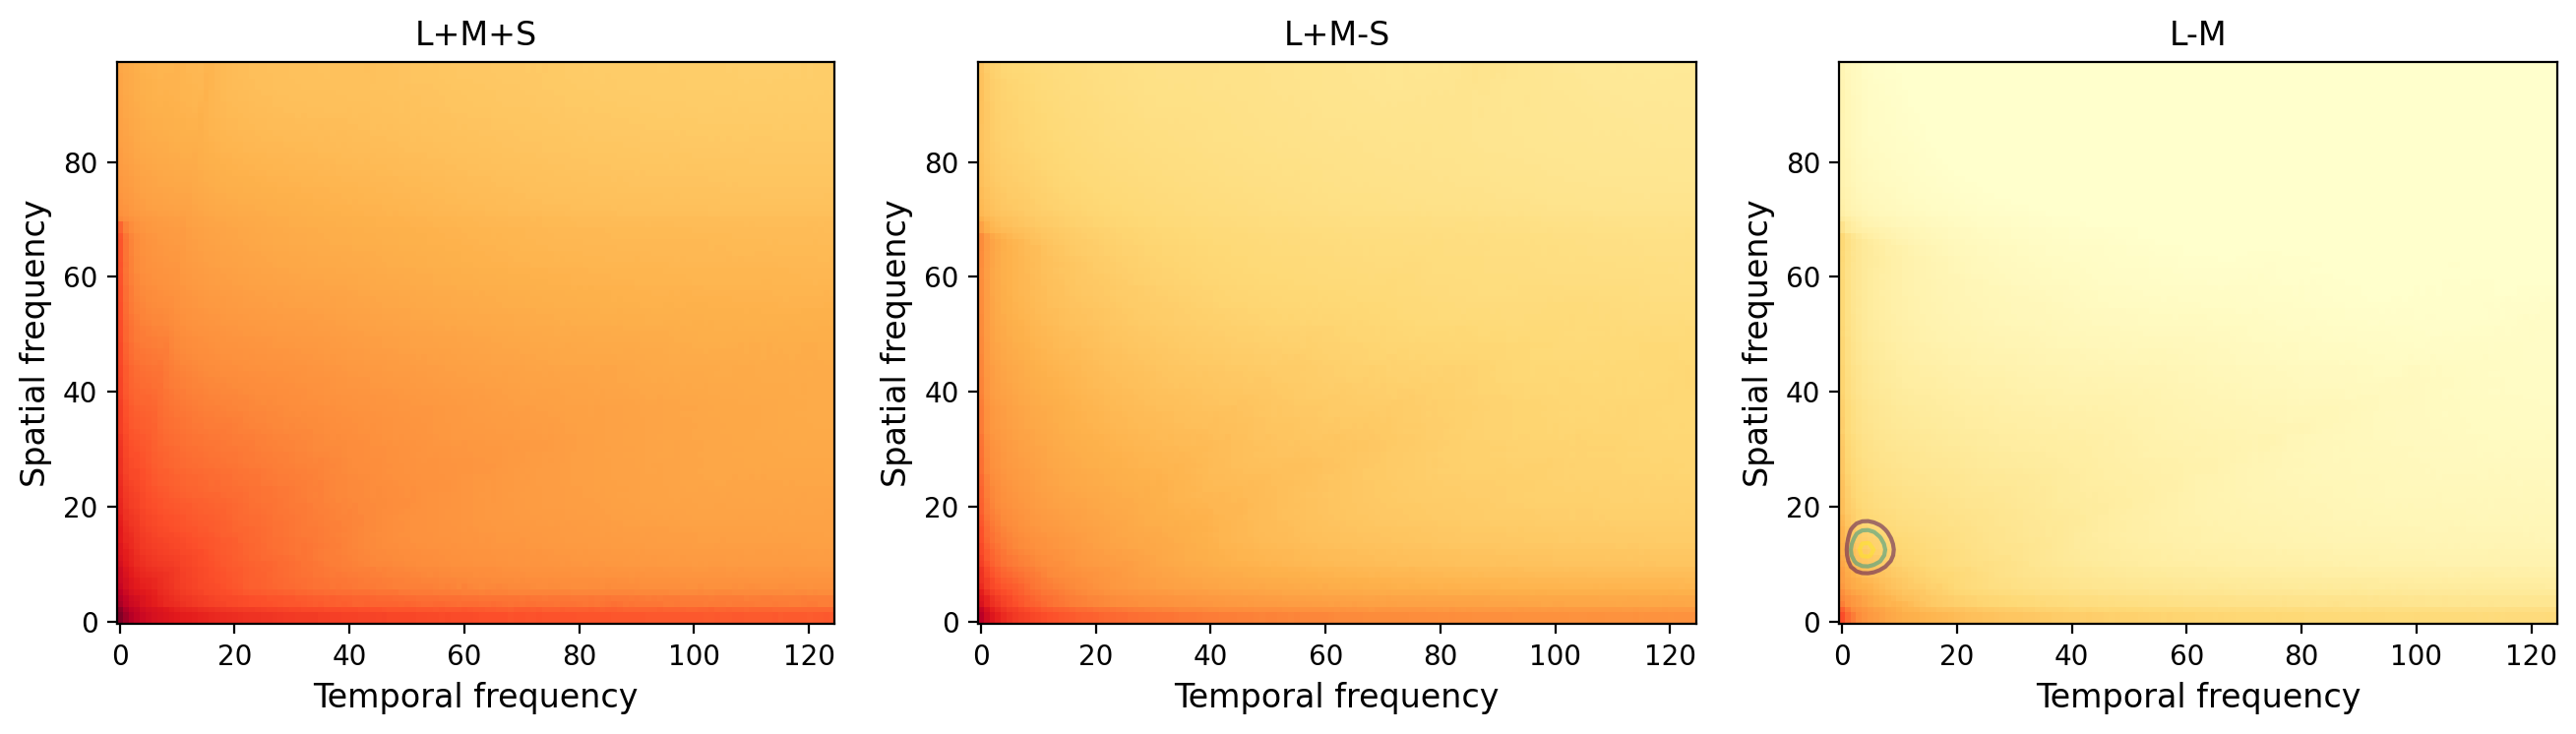

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
fig2, ax2 = plt.subplots(1,3, figsize = (16,8))
fig3, ax3 = plt.subplots(1,3,figsize = (16,8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_min = 0
k_max = 95
w_min = 0
w_max = 60
k_indices = np.linspace(k_min, k_max -1, k_max - k_min)
w_indices = np.linspace(w_min, w_max -1, w_max - w_min)
#omega_indices = np.array([0,10,20,30,40,50,60])
omega_indices = np.array([0,10,20,30,40])

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []

vv2_all = []
vf2_all = []
log_v_all = []
log_v_a_all = []
RF_omega_pre_all = []
RF_omega_all = []

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']
RFs = []

for fixed_omega in omega_indices:
    log_eps = optimal_logeps(fixed_omega, k_indices, None, P, 'temporal')
    #log_eps = log_eps[::-1]
    #print(log_eps)
    vspace_omega = []
    RFs_omega = []
    for i in range(n_channels):
        vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)
        #vv_lms = np.matmul(vv,U[:,fixed_omega,i,:])
        #if i == 0:
        #    vv_lms_sum = vv_lms
        #else:
        #    vv_lms_sum += vv_lms 
        
        
        #vv = vv[:,0]
        #vv = vv[::-1]
        vv_all.append(vv)
        #if np.max(vv) > 0:
        #vf = np.convolve(vv[N//2:], ff, mode='same')
        vf = np.convolve(vv[vv.shape[0]//2:], ff, mode = 'same')
        
        
        vf_all.append(vf)
        #The bug is here :) in the fft convention~
        #print(vf.shape)
        vvf = pad_and_reflect(vf, vf.shape[0]*2)
        #vvf = vf
        
        vvf_all.append(vvf)
        vspace = np.real(scipy.fft.fft(vvf))
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        frequencies = np.linspace(0, vv.shape[0], vv.shape[0])-vv.shape[0]/2 + 0.5
        line, = ax[i].plot(frequencies, vv, color = colors[c], label = str(('{:.3f}').format(fixed_omega)))
        
        center = int(vspace.shape[0]/2)
        plot_range = 50
        #ax[i].set_xlim(center - plot_range, center + plot_range)   
        #ax[i].set_yticks([])
        ax[i].set_xlabel(r"$k$")
        ax[i].set_title(r"Spatial filter in Fourier space for " + channel_labels[i]);

        vf_argmax = np.argmax(vf)
        log_eps2 = optimal_logeps(vf_argmax, w_indices, None, P, 'spatial')
        vv2 = filter_k(vf_argmax, w_indices, 10**log_eps2[i], 'spatial', i)(w_indices)
        vv2_all.append(vv2)
        
        #Prevents artifacts when output filter is 0 for all freqs. 
        vf2 = np.convolve(vv2[vv2.shape[0]//2:], ff, mode='same')
        vf2_all.append(vf2)
        
        log_v = extrap_and_reflect(vf2, vv2.shape[0], return_log=True)
        log_v_all.append(log_v)
        
        log_v_a = np.conj(ssig.hilbert(log_v))
        log_v_a_all.append(log_v_a)
        vt = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
        #RF_omega = np.outer(vf,vt[0:int(vt.shape[0]/2)])
        RF_omega_pre = np.outer(vf,vf2)
        RF_omega_pre_all.append(RF_omega_pre)
        #RF_omega = np.roll(RF_omega, -fixed_omega + 40, axis = 1)
        RF_omega = np.roll(RF_omega_pre, fixed_omega, axis = 1)
        RF_omega = np.roll(RF_omega, vf_argmax, axis = 0)
        RFs_omega.append(RF_omega)
        #RFs_omega.append(RF_omega)
    RFs_omega = np.array(RFs_omega)#[:,:,::-1]
    RFs.append(RFs_omega)
    
    lines.append(line)
    c += 1    
ax[i].legend(handles=lines, title = "Temporal frequency", fontsize = 12)
RFs = np.array(RFs)
percentile_values = [99,99.5,99.9]
for i in range (3):
    ax3[i].imshow(np.log(Cx[:,:,i]), origin = 'lower', cmap = 'YlOrRd', vmin = 0, vmax = np.max(np.log(Cx)))
    for fixed_omega in range(omega_indices.shape[0]):
        contour_values = []
        for percentile in percentile_values:
            contour_values.append(np.percentile(RFs[fixed_omega,i,:,:], percentile) + percentile*10e-32)
        ax3[i].contour(RFs[fixed_omega, i,:,:], contour_values, origin = 'lower', alpha = 0.5)
        
    ax3[i].set_title(channel_labels[i])
    ax3[i].set_xlabel("Temporal frequency", size = 12)
    ax3[i].set_ylabel("Spatial frequency", size = 12)
    #ax[0].text(*label_loc, r'\textbf{B}', transform=ax[0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    #cbar = fig.colorbar(s)
    #cbar.ax.tick_params(labelsize=50)

In [37]:
Cx.shape
np.mean(Cx[:,0,0]/1000000000)

17.387464197962448

[ 0.0092262   0.10002928 -1.67520238]
[ 0.12562239 -0.87414447 -1.19001932]
[-0.24448917 -0.1857413  -1.74825917]
[ 0.02736553 -1.65916186 -1.74134093]


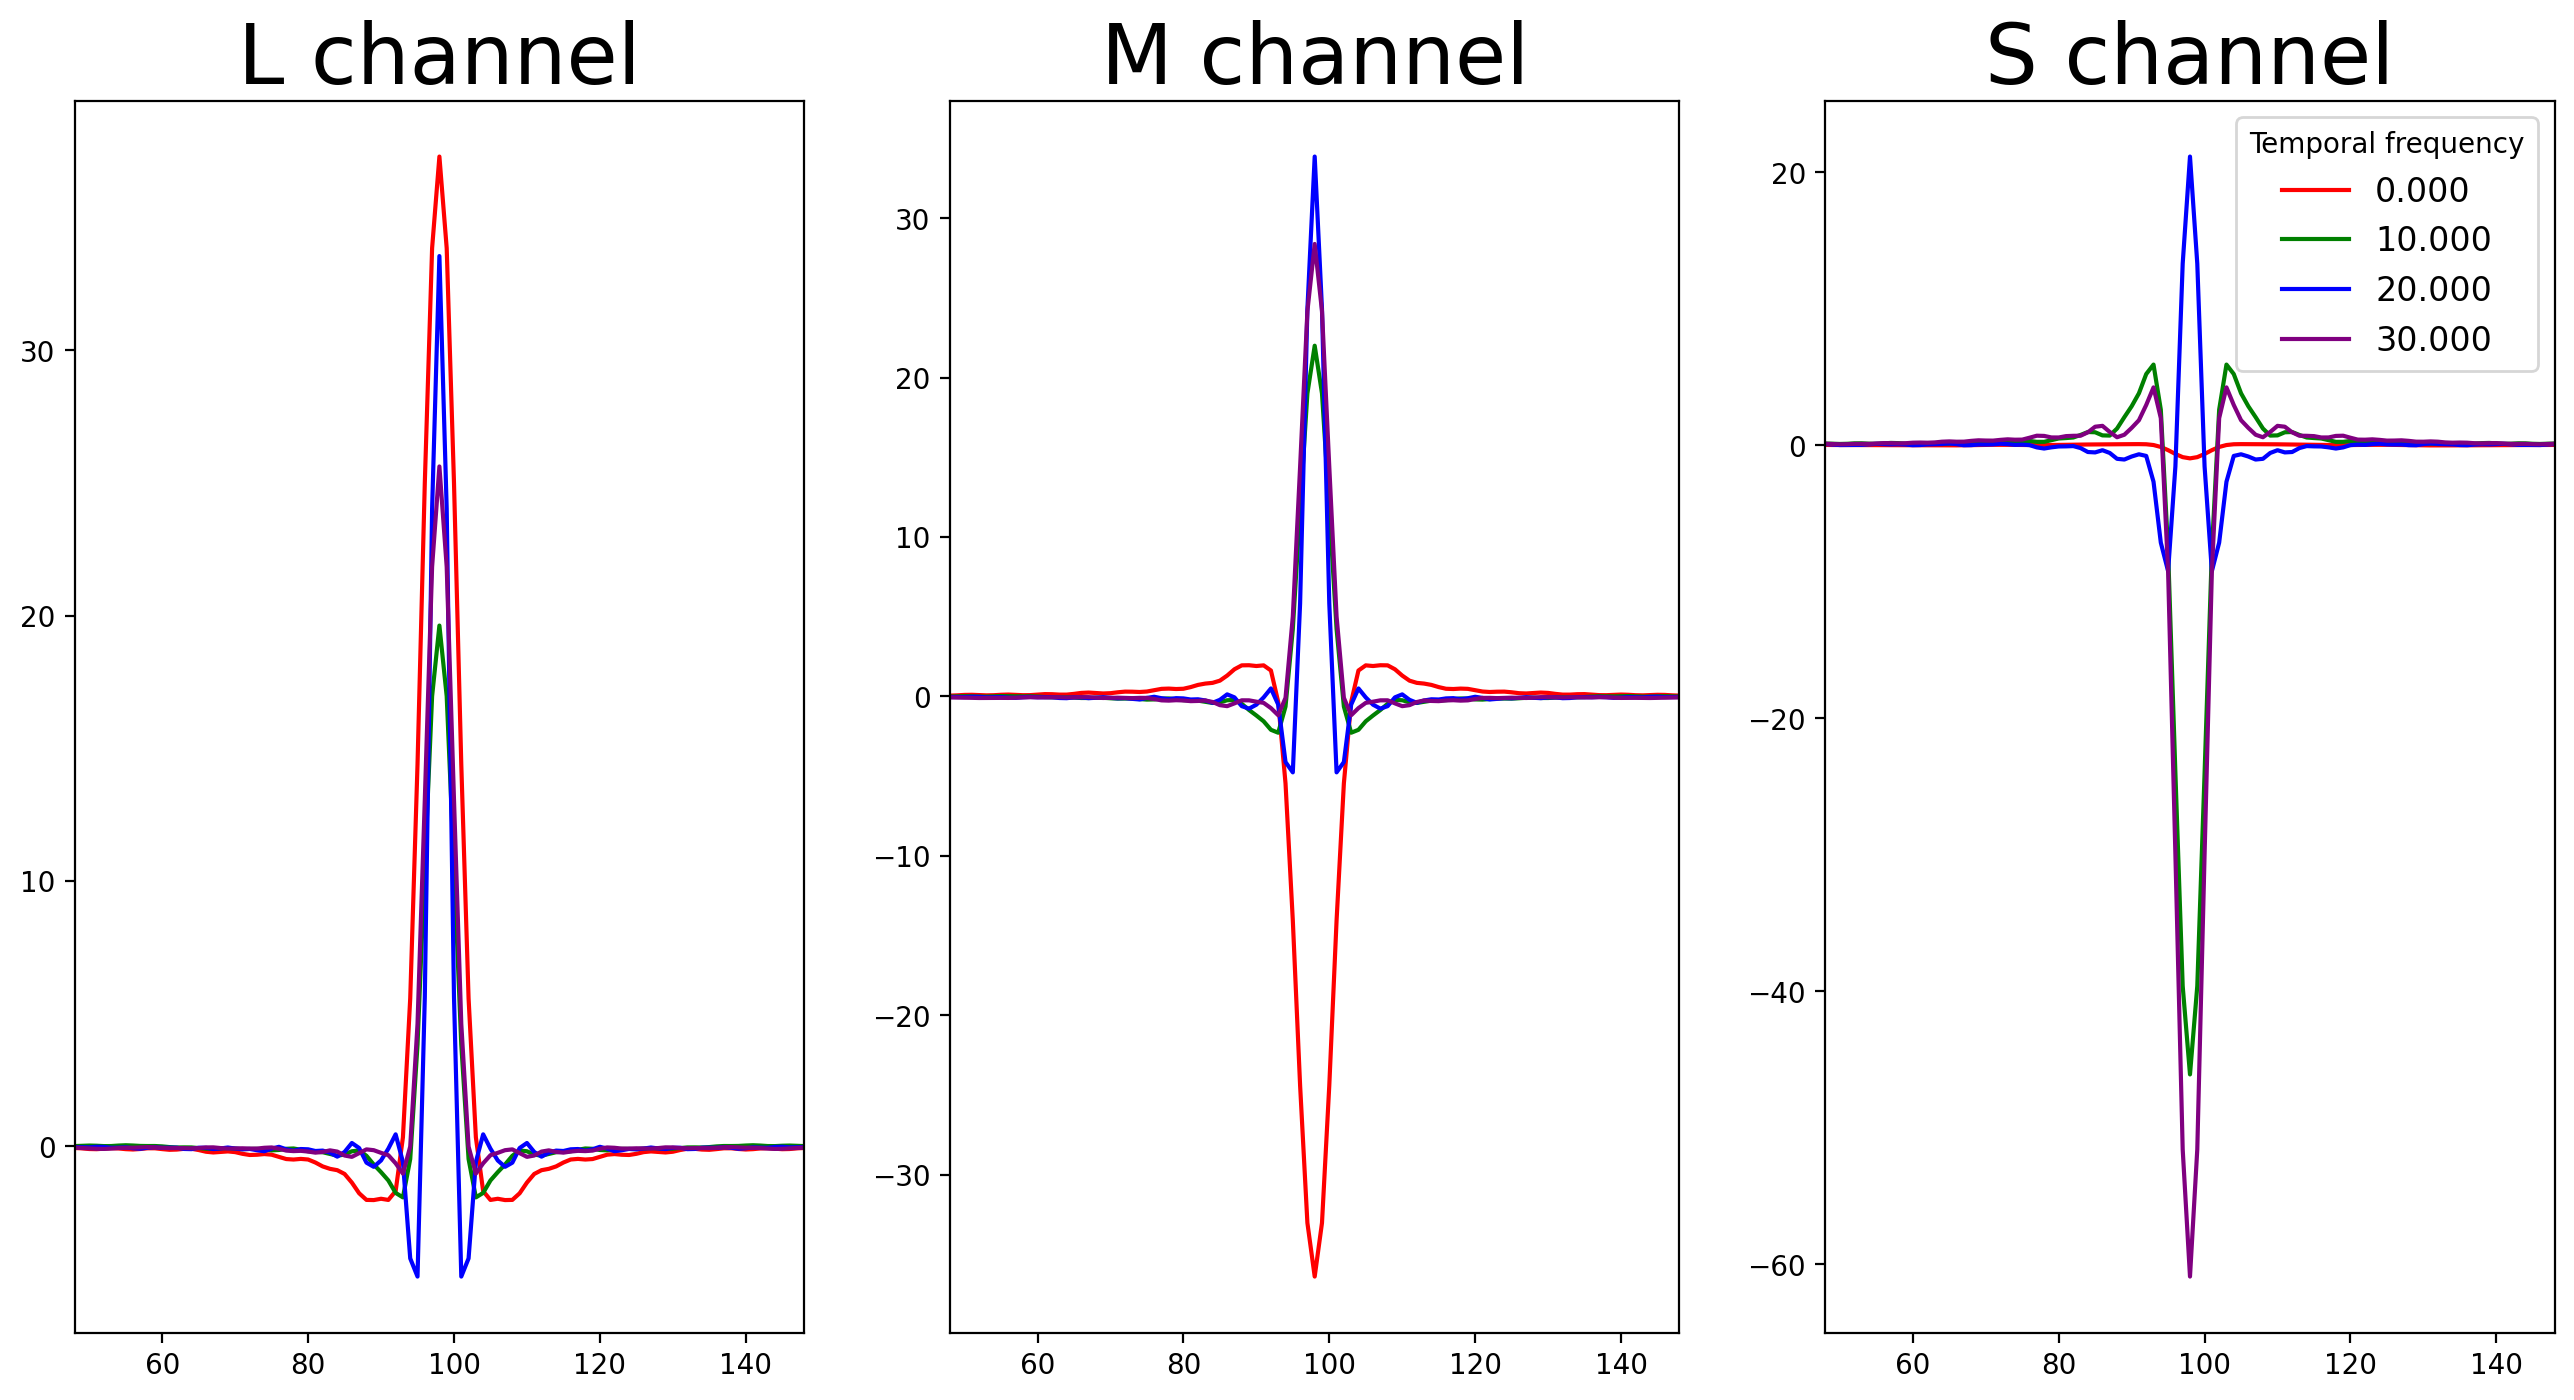

In [38]:
lms_space = True
#if lms_space:
#    v_temp = np.zeros(vv.shape[0])
#    for j in range(n_channels):
#        v_temp += vv*U[:,fixed_omega,j,i]
#    vv = v_temp

fig, ax = plt.subplots(1, 3, figsize=(16, 8))
P = 1
#dz = 1e-4
N = Cx.shape[0]
dz = 1#Cx.shape[0]/N

#In hindsight, these should be indices instead of frequencies!!! *IMPORTANT
#John: dz = 1/n_pixels 
#Lower frequency is 2*pi/L

#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
#freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)

k_min = 0
k_max = 98
k_indices = np.linspace(k_min, k_max -1, k_max - k_min)
omega_indices = np.array([0,10,20,30])
#omega_indices = np.array([0,15,45,65])

#freqs_k = (scipy.fft.fftfreq(N, d=dz) * np.pi)[0:N//2+1

#freqs_k = Cx.shape[0]*freqs_k[0:int(N/2)]/np.max(freqs_k[0:int(N/2)])


#freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (len(k_indices)//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2,.2, 0.01)
ff = np.exp(-20 * np.abs(fz))
ff /= np.sum(ff)
vv_all = []
vf_all = []
vvf_all = []
vspace_all = []
eig_RFs = []
nus = []
powers = []
MIs = []
log_eps_all = []

colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'yellow', 'pink', 'darkred', 'olive']
c = 0
lines = []
channel_labels = ['L+M+S', 'L+M-S', 'L-M']

for fixed_omega in omega_indices:
    log_eps = optimal_logeps(fixed_omega, k_indices, None, P, 'temporal')
    log_eps_all.append(log_eps)
    compute_MI = create_information_eps(fixed_omega, k_indices, 'temporal', False)
    MIs.append(compute_MI(log_eps))
    #log_eps = log_eps[::-1]
    print(log_eps)
    nus.append(10**log_eps)
    vspace_omega = []
    vf_omega = []
    power_omega = []
    for i in range(n_channels):
        power = filter_power(10**log_eps[i], fixed_omega, k_indices, None, i, 'temporal')
        power_omega.append(power)
        vv = filter_k(fixed_omega, k_indices, 10**log_eps[i], 'temporal', i)(k_indices)
        vv_all.append(vv)
        vv = vv[vv.shape[0]//2:]
        vf = np.convolve(vv, ff, mode = 'same')
        vf_omega.append(vf)
        vf_all.append(vf)
        vvf = pad_and_reflect(vf, vf.shape[0]*2)
        vvf_all.append(vvf)
        vspace = np.real(scipy.fft.fft(vvf))
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        vspace_omega.append(vspace)
    powers.append(power_omega)
    vspace_all.append(vspace_omega)
    eig_RFs.append(vf_omega)
log_eps_all = np.array(log_eps_all)
powers = np.array(powers)
MIs = np.array(MIs)
eig_RFs = np.array(eig_RFs) # omegas x colors x space_freqs
lms_RFs = np.zeros(eig_RFs.shape)
omega_index = -1
lms_titles = ["L channel", "M channel", "S channel"]
for omega in omega_indices:
    omega_index += 1
    for eig_c in range(n_channels):
        lms_RFs[omega_index,:,:] += (np.sqrt(eig_RFs[omega_index,eig_c,:,np.newaxis])*U[:,omega,:,eig_c]).T
    for color in range(n_channels):
        vvf = pad_and_reflect(lms_RFs[omega_index,color,:], lms_RFs.shape[2]*2)
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        line, = ax[color].plot(vspace, color = colors[omega_index], label = str(('{:.3f}').format(omega)))
        ax[color].set_title(lms_titles[color], size = 30)
        
        center = int(vspace.shape[0]/2)
        plot_range = 50
        ax[color].set_xlim(center - plot_range, center + plot_range) 
    lines.append(line)
ax[2].legend(handles=lines, title = "Temporal frequency", fontsize = 12)

In [39]:
print(10**log_eps_all)
print(MIs)
print(powers)

[[1.02147137 1.25901028 0.02112504]
 [1.33543388 0.1336151  0.06456255]
 [0.56952243 0.65201667 0.01785422]
 [1.06503904 0.02191988 0.01814091]]
[[ 0.          0.         11.48766299]
 [ 0.          5.21520398  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          5.0662096   0.        ]]
[[0.         0.         1.        ]
 [0.         1.         0.        ]
 [0.99686958 0.00313049 0.        ]
 [0.         1.         0.        ]]


# Power as a function of $\nu$

In [1]:
infos = []
fixed_freq = 20
fixed_type = 'temporal'
for i in range(n_channels):
    eps_eigenchannel = 10**log_eps[i]
    if fixed_type == 'spatial':
        ktilde = 1/Cx[int(fixed_freq),:, i]
    elif fixed_type == 'temporal':
        ktilde = 1/Cx[:,int(fixed_freq), i]
    numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-32)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) - 1) - sigout**2) + sigout**2
    denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) + 1) - sigout**2) + sigout**2
    info = np.sum(np.log(numer) - np.log(denom))
    infos.append(info)
    infos_output = np.sum(infos)*-1
plt.plot(np.log(numer) - np.log(denom))

NameError: name 'n_channels' is not defined

/tmp/ipykernel_237771/471616026.py:66: RuntimeWarning: divide by zero encountered in log
  extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')


False

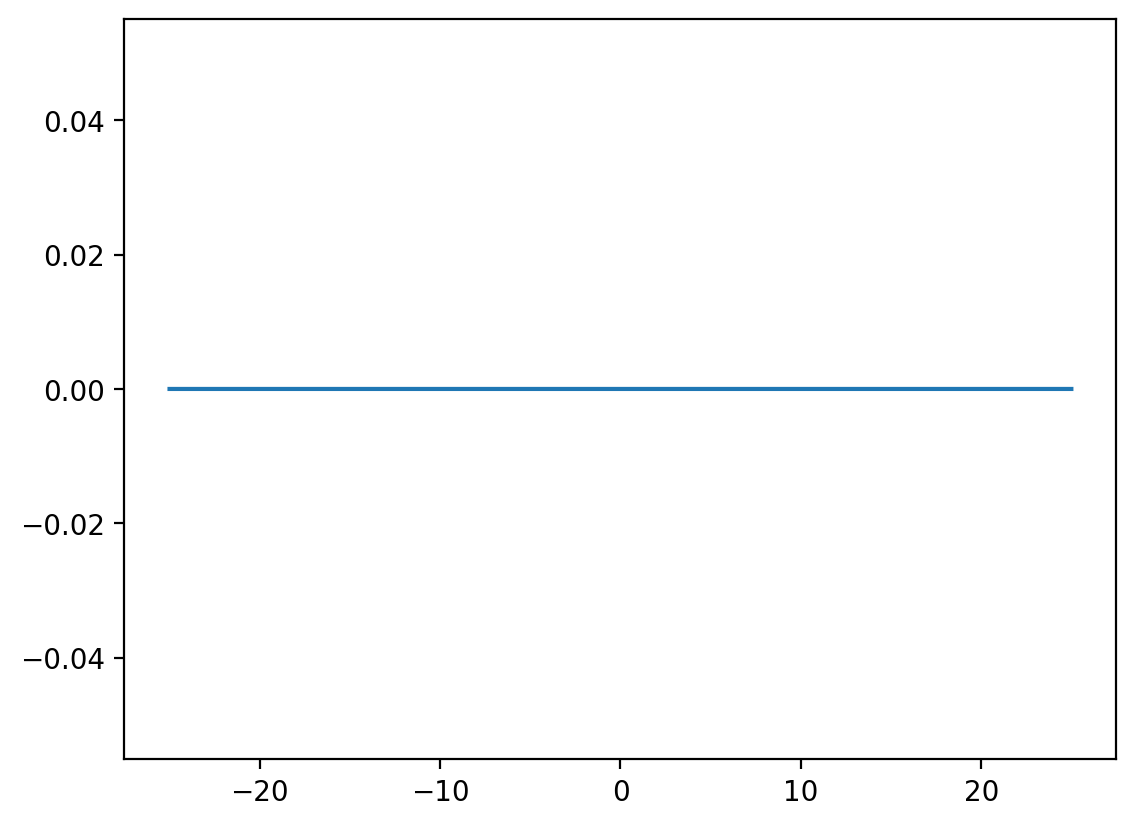

In [349]:
#This snippet is for debugging purposes 

M = 1000001
T = (M//2) * dt
tt = np.linspace(-T/2, T/2, M)
vv = vv_all[2]
vf = np.convolve(vv[M//2:], ff, mode='same')
log_v = extrap_and_reflect(vf, M, return_log=True)
log_v_a = np.conj(ssig.hilbert(log_v))
vt_prenorm = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
vt = vt_prenorm/np.linalg.norm(vt_prenorm)
#plt.plot(tt,  vv_all[2])
plt.plot(tt, vv)
np.max(vv) > 0
#plt.xlim(-0.35,0.05)

In [18]:
sigout

1.25